In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2

import torch

from model import Net
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

model = Net()

# load checkpoints
checkpoints = torch.load('model.pth')

model.load_state_dict(checkpoints['state_dict'])
model.to(device)

# set model to evaluation mode
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [0]:
def filter(path):

  ################################################################ORIGINAL IMAGE

  # load the file
  try:
    image = cv2.imread(path)
  except:
    print("File doesn't exist at the path mentioned")

  # conver color from BGR to RGB
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # plot image
  fig = plt.figure(figsize=(9,9))
  plt.axis('off')
  plt.title('Original Image')
  plt.imshow(image)
  ###################################################################DETECT FACE

  # load in a haar cascade classifier for detecting frontal faces
  face_cascade = cv2.CascadeClassifier('cascades/haarcascade_frontalface_default.xml')

  # run the detector
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)

  # make a copy of the original image to plot detections on it
  image_copy = image.copy()

  # loop over the detected faces and mark them on the image
  for (x,y,w,h) in faces:
    # draw a rectangle around each face
    cv2.rectangle(image_copy, (x,y),(x+w,y+h),(255,0,0),2)

  fig = plt.figure(figsize=(9,9))
  plt.title('Face being Detected by Haar Cascades')
  plt.axis('off')
  plt.imshow(image_copy)

  #####################################################################KEYPOINTS

  PADDING = 100

  image_copy = image[y-PADDING:y+h+PADDING, x-PADDING:x+w+PADDING]
  image_copy = cv2.resize(image_copy, (224,224))
  # pad the gray image of the detected face region
  gray_padded = gray[y-PADDING:y+h+PADDING, x-PADDING:x+w+PADDING]

  # normalize it
  roi = (gray_padded / 255).astype(np.float32)

  # rescale the image to 224 for input to model
  roi = cv2.resize(roi, (224,224))

  # Conver image to channel x height x width
  roi = roi.reshape(224,224,1)
  roi = roi.transpose(2,0,1)


  # Match the convolution dimensions by making image of batchsize 11
  roi = np.expand_dims(roi, axis=0)

  # Forward pass
  roi = torch.from_numpy(roi).type(torch.FloatTensor)
  roi = roi.to(device)
  output_points = model.forward(roi)

  output_points = output_points.view(output_points.size(0),68,-1)

  keypoints = output_points.data.cpu().numpy()
  keypoints = keypoints * 50.0 + 100
  keypoints = keypoints[0]

  fig = plt.figure(figsize=(9,9))
  plt.title('Keypoints')
  plt.imshow(image_copy)
  plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.',c='red')
  plt.axis('off')
  plt.show()
  ########################################################################FILTER

  # top-left location for sunglasses to go
  # 17 = edge of left eyebrow
  x = int(keypoints[17, 0] - 20)
  y = int(keypoints[17, 1] - 30)

  # height and width of sunglasses
  # h = length of nose
  h = int(abs(keypoints[27,1] - keypoints[34,1]) +60)
  # w = left to right eyebrow edges
  w = int(abs(keypoints[17,0] - keypoints[26,0]) + 50)

  x2 = int(keypoints[27,0] - 50)
  y2 = int(keypoints[27,1] + 20)
  h2 = h - 40
  w2 = w - 40

  # read in sunglasses and mustache
  sunglasses = cv2.imread('images/glasses.png', cv2.IMREAD_UNCHANGED)
  mustache = cv2.imread('images/mustache.png', cv2.IMREAD_UNCHANGED)
  # resize sunglasses and mustache
  new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)
  mustache =  cv2.resize(mustache, (w2, h2), interpolation = cv2.INTER_CUBIC)

  ################################################
  # get region of interest on the face to change
  roi_color = image_copy[y:y+h,x:x+w] 
  
  # find all non-transparent pts
  ind = np.argwhere(new_sunglasses[:,:,3] > 0)

  # for each non-transparent point, replace the original image pixel with that of the new_sunglasses
  for i in range(3):
      roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
  # set the area of the image to the changed region with sunglasses
  image_copy[y:y+h,x:x+w] = roi_color

  ###############################################
  # get region of interest on the face to change
  roi_color = image_copy[y2:y2+h2,x2:x2+w2] 
  
  # find all non-transparent pts
  ind = np.argwhere(mustache[:,:,3] > 0)

  # for each non-transparent point, replace the original image pixel with that of the mustache
  for i in range(3):
      roi_color[ind[:,0],ind[:,1],i] = mustache[ind[:,0],ind[:,1],i]    
  # set the area of the image to the changed region with sunglasses
  image_copy[y2:y2+h2,x2:x2+w2] = roi_color


  # display the result!
  fig = plt.figure(figsize=(9,9))
  plt.title('After Applying Filter')
  plt.imshow(image_copy)
  plt.axis('off')

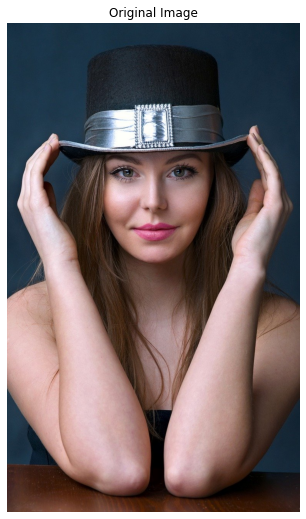

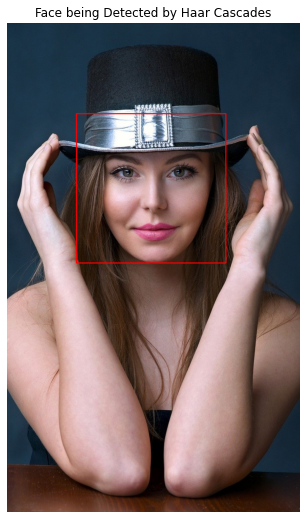

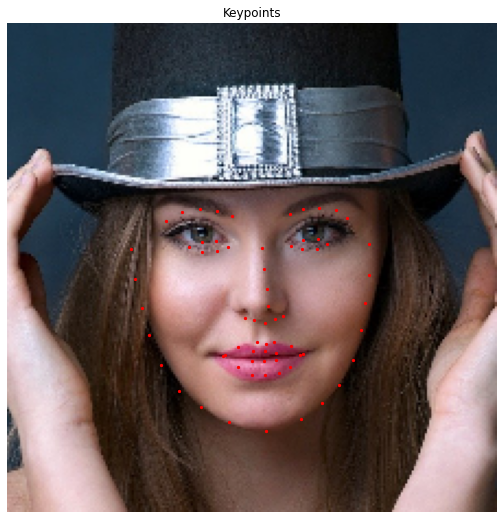

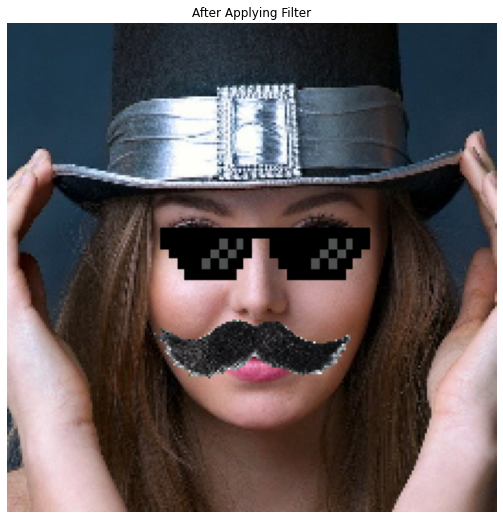

In [0]:
filter('images/girl.jpg')

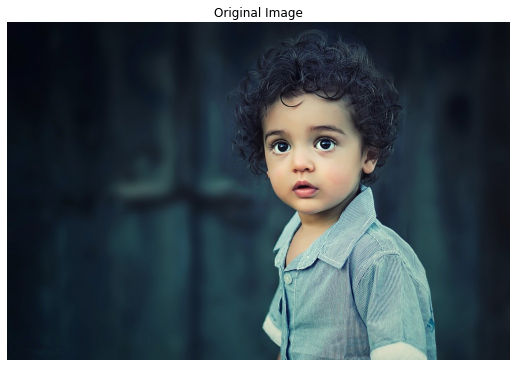

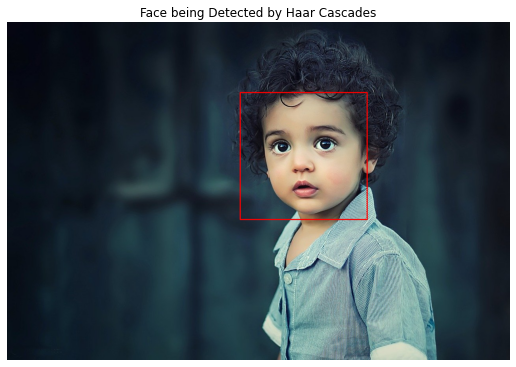

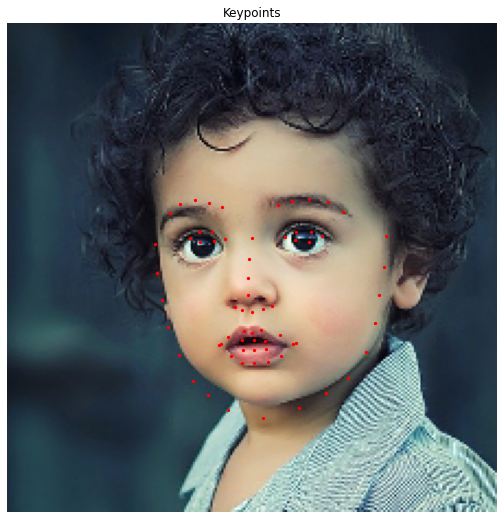

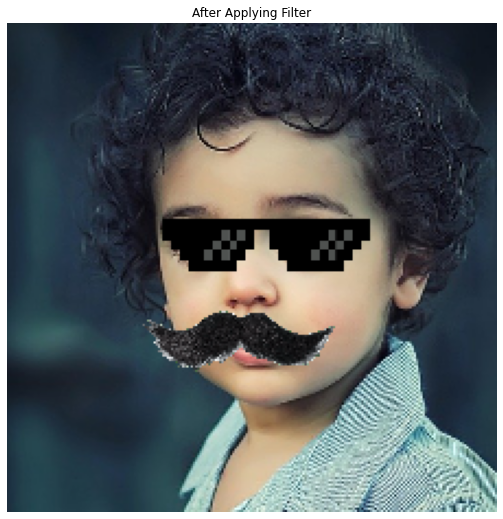

In [0]:
filter('images/child-817373_1280.jpg')